# Group Map

## Theory

Illustrate the use of `groupmap`, that defines `GroupMap`, `InstanceMap`, `LayerMap` modules, to transform the input so that it follows a prescribed arbitrary distribution, like uniform, Gaussian, sparse, etc. 

> The main difference between the `GroupMap`, `InstanceMap` and `LayerMap` modules and their normalization-based counterparts `GroupNorm`, `InstanceNorm` and `LayerNorm` is they enforces the output to match _a whole distribution_ instead of just mean and variance.
> :warning: In this simplified implementation, there is no tracking of the input statistics and the module always uses the batch statistics for mapping, both at training and test time. 


Let $x$ be the input tensor, of arbitrary shape `(B, C, ...)` and let $x_{nc\boldsymbol{f}}$ be one of its entries for sample $n$, channel $c$ and a tuple of indices $\boldsymbol{f}$ corresponding to features. For instance, for images, we would have 2D features $\boldsymbol{f}=(i,j)$ for the row and column of a pixel. 

For each element of the input tensor, the following transformation is applied:

$y_{nc\boldsymbol{f}}=\mathit{Q}\left(\mathcal{F}_{nc}\left(x_{nc\boldsymbol{f}}\right)\right) * \gamma_{c\boldsymbol{f}} + \beta_{c\boldsymbol{f}}$

Where:  
* $\forall q\in[0, 1],~\mathit{Q}(q)\in\mathbb{R}$ is the target _quantile function_. It describes what the distribution of the output should be and is provided by the user. The `GroupMap` module guarantees that the output will have a distribution that matches this target.
    > Typically, $\mathit{Q}$ is the quantile function for a classical distribution like uniform, Gaussian, Cauchy, etc.
    $\mathit{Q}(0)$ is the minimum of the target distribution, $\mathit{Q}(0.5)$ its median, $\mathit{Q}(1)$ its maximum, etc.
* $\mathcal{F}_{nc}(v)=\mathbb{P}(x_{nc,\boldsymbol{f}}\leq v)\in[0, 1]$  is the input cumulative distribution function (cdf) for sample $n$ and channel $c$.
   It is estimated on data for sample $n$. Several behaviours are possible, depending on which part of $x_n$ it is computed from.
   * It can be the cdf for just a particular channel $x_{nc}$, then behaving like some optimal-transport version of `InstanceNorm`.
   * It can be computed and shared over all channels of sample $x_n$  (as in `LayerNorm`)
   * It can be computed and shared over groups of channels (as in `GroupNorm`).
    > $\mathcal{F}_{nc}(v)=0$ if $v$ is the minimum of the input distribution, $0.5$ for the median, $1$ for the maximum, etc.).  
* $\gamma_{c\boldsymbol{f}}$ and $\beta_{c\boldsymbol{f}}$ are parameters for an affine transform that may or may not be activated. If it is activated, it matches classical behaviour, i.e. we have $\gamma_{c\boldsymbol{f}}=\gamma_{c}$ and $\beta_{c\boldsymbol{f}}=\beta_{c}$ for `InstanceMap` and `GroupMap`, while elementwise parameters for `LayerMap`.

This formula corresponds to the classical _increasing rearrangement_ method to optimally transport scalar input data distributed wrt a distribution to another scalar distribution, by mapping quantile to quantile (min to min, median to median, max to max, etc.)  


## Example: transport a small tensor

In [1]:
# import
import torch
from torch import nn
from groupmap import GroupMap, LayerMap, InstanceMap
import groupmap


/home/antoine/anaconda3/envs/1.12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialize a small `(3, 4)` tensor randomly and transport it with a uniform target, with different numbers of groups

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create a dummy tensor with 4 channels and 4 features
v = torch.randn(1, 4, 4).to(device)
print('original data')
print(v[0].cpu().numpy())

# groupmap with each row as a group (as in instancenorm)
gm = GroupMap(
    num_groups=4,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with each row as a group')
print(gm(v)[0].detach().cpu().numpy())

# groupmap with all rows together (as in layernorm)
gm = GroupMap(
    num_groups=1,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with all rows together as a group')
print(gm(v)[0].detach().cpu().numpy())

# groupmap with groups of 2 consecutive rows (as in groupnorm)
gm = GroupMap(
    num_groups=2,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with 2 groups (two consecutive rows together)')
print(gm(v)[0].detach().cpu().numpy())

original data
[[ 0.08382922  0.45447978 -0.25317284 -0.5728172 ]
 [-2.2426524  -0.28351995 -0.08615109  0.59332186]
 [ 1.1388981   2.0462804  -0.1348386  -0.761024  ]
 [-1.4253976  -0.30434617 -0.6643941  -0.827491  ]]

groupmap with each row as a group
[[0.6666666  1.         0.33333334 0.        ]
 [0.         0.33333334 0.6666666  1.        ]
 [0.6666666  1.         0.33333334 0.        ]
 [0.         1.         0.6666666  0.33333334]]

groupmap with all rows together as a group
[[0.73333335 0.8        0.5333333  0.33333334]
 [0.         0.4666667  0.6666666  0.8666667 ]
 [0.93333334 1.         0.59999996 0.20000002]
 [0.06666667 0.40000004 0.26666668 0.13333334]]

groupmap with 2 groups (two consecutive rows together)
[[0.71428573 0.85714287 0.42857146 0.14285715]
 [0.         0.2857143  0.57142854 1.        ]
 [0.85714287 1.         0.71428573 0.2857143 ]
 [0.         0.57142854 0.42857146 0.14285715]]


As can be seen, the minimum value for each group gets `0`, the max gets `1`, and in-between get the appropriate quantile value.

## Example: for image processing

### Data loading

In [3]:
# DATA
available_datasets = {'celeba', 'cifar10', 'mnist'}
dataset = 'celeba'
batchsize = 16

from torchvision.datasets import CelebA, CIFAR10, MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

if dataset=='celeba':
    dataset = CelebA(root='/data', split='train', download=True, transform=trans)
elif dataset=='cifar10':
    dataset = CIFAR10(root='/data', train=True, download=True, transform=trans)
elif dataset=='mnist':
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))])
    dataset = MNIST(root='/data', train=True, download=True, transform=trans)
    
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified


### Create groupmap and normalization modules

Now create a `GroupMap` and different normalization modules. Allocating many of them to see if that scales to deep architectures

In [4]:
num_groups = 1
num_channels=dataset[0][0].shape[0]

# creating a groupmap
gm = GroupMap(
            num_groups = num_groups,
            num_channels = num_channels,
            target_quantiles = groupmap.uniform,
).to(device)

# creating a layermap
lm = LayerMap(
            normalized_shape = dataset[0][0].shape,
            elementwise_affine = True,
            target_quantiles = groupmap.uniform,
).to(device)

# creating an instancemap
im = InstanceMap(
            num_features = num_channels,
            affine = True,
            target_quantiles = groupmap.uniform,
).to(device)

# creating a groupnorm
gn = nn.GroupNorm(
            num_groups = num_groups,
            num_channels = num_channels
).to(device) 

# creating a layernorm
ln = nn.LayerNorm(
            normalized_shape=dataset[0][0].shape[1:],
            elementwise_affine = False
).to(device)

# creating an instancenorm
inn = nn.InstanceNorm2d(
            num_features=num_channels
).to(device) 


### Display statistics

Create an utilitary function to plot statistics of groups

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from einops import rearrange

def plot_statistics(v, num_groups, num_samples=4, title=None):
    v = v[:num_samples]
    batchsize, num_channels = v.shape[:2]
    v = v.view(batchsize, num_channels, -1)
    v = rearrange(v,'b (g p) f -> b g (p f)', g=num_groups)
    fig = plt.figure(figsize=(20,3))
    gs = fig.add_gridspec(num_groups, batchsize, hspace=0, wspace=0.2)
    axes = gs.subplots()
    for g, n in product(range(num_groups), range(batchsize)):
        if num_groups==1:
            ax = axes[n]
        else:
            ax = axes[g][n]
        sns.histplot(data=v[n,g,:].cpu().numpy(), ax=ax, bins=100)
        if not g:
            ax.set_title(f'sample {n+1}')
    if title:
        plt.suptitle(title)
    #plt.tight_layout()
    plt.show()

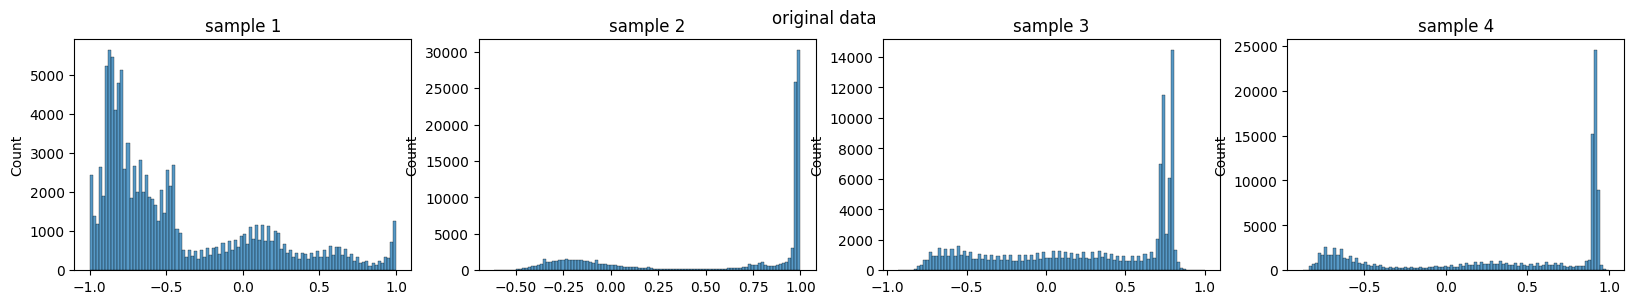

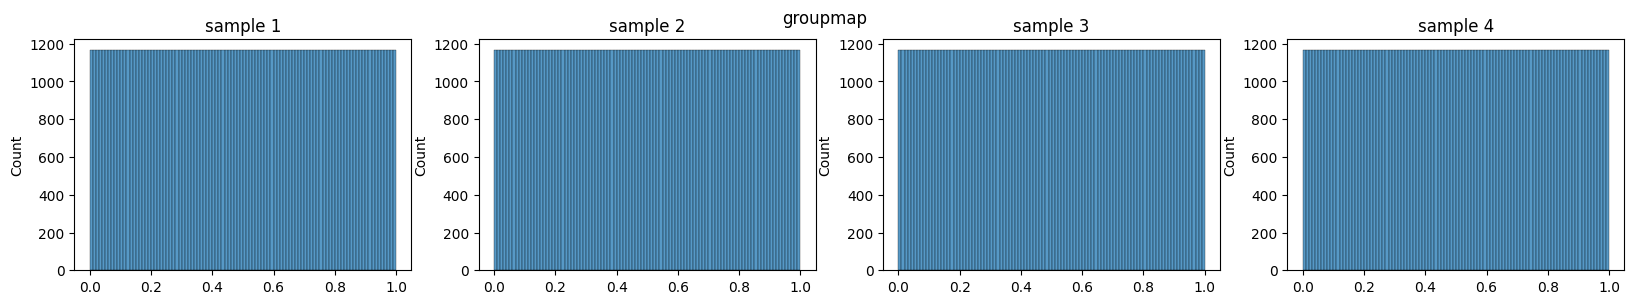

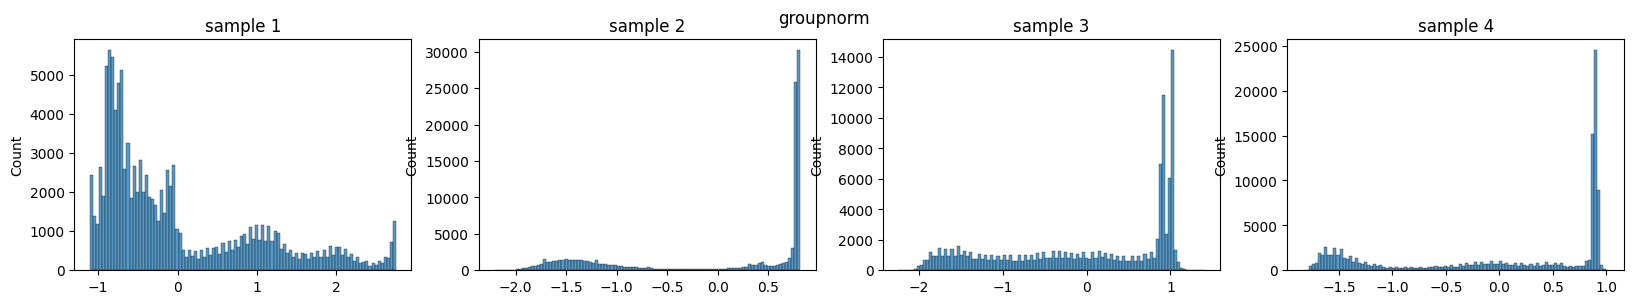

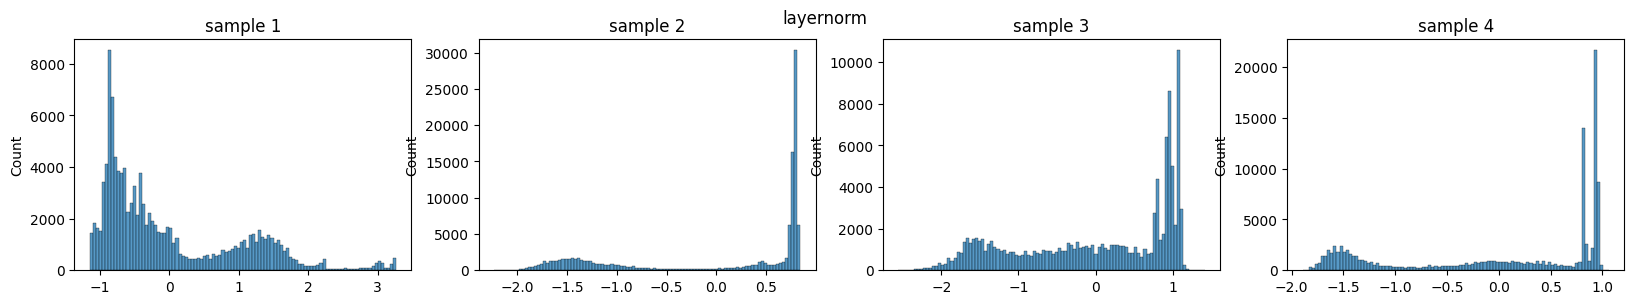

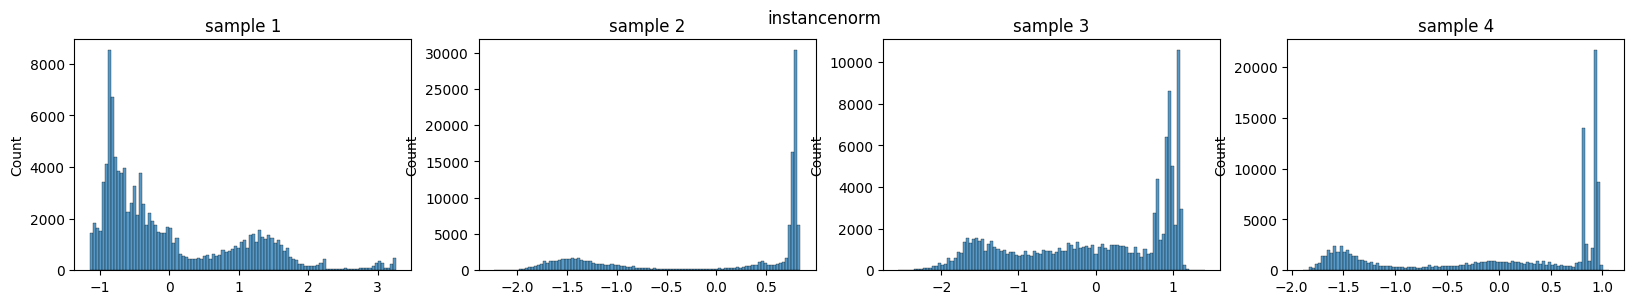

In [6]:
# plot the statistics of the first 4 samples of a batch

x = next(iter(dataloader))[0].to(device)
plot_statistics(x.detach().cpu(), num_groups,num_samples=4, title='original data'); 
plot_statistics(gm(x).detach().cpu(), num_groups,num_samples=4, title='groupmap'); 
plot_statistics(gn(x).detach().cpu(), num_groups,num_samples=4, title='groupnorm'); 
plot_statistics(ln(x).detach().cpu(), num_groups,num_samples=4, title='layernorm'); 
plot_statistics(inn(x).detach().cpu(), num_groups, title='instancenorm'); 

### Display images

and now some displays at time measures

776 µs ± 99.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
761 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
758 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 5.73 times longer than the fastest. This could mean that an intermediate result is being cached.
85.5 µs ± 65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.9 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
55.4 µs ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


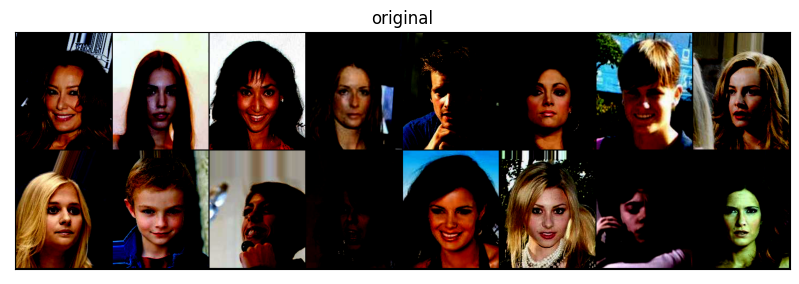

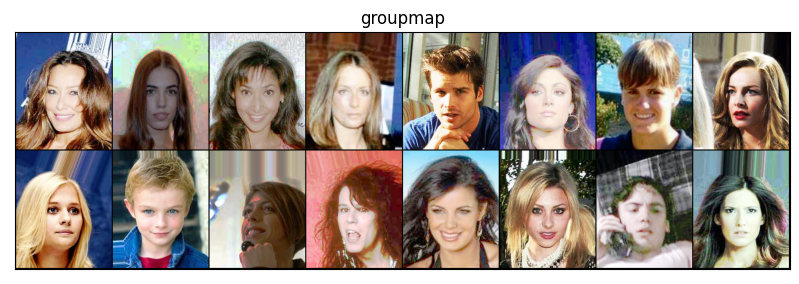

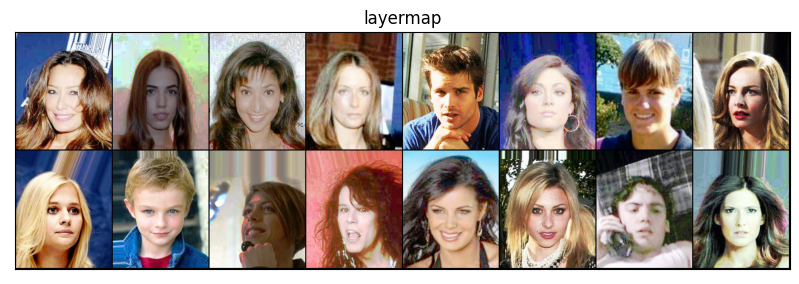

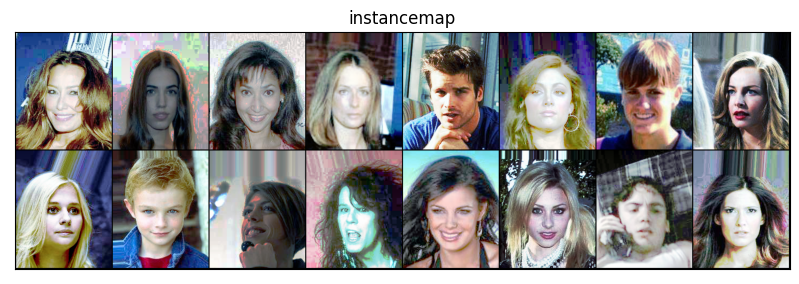

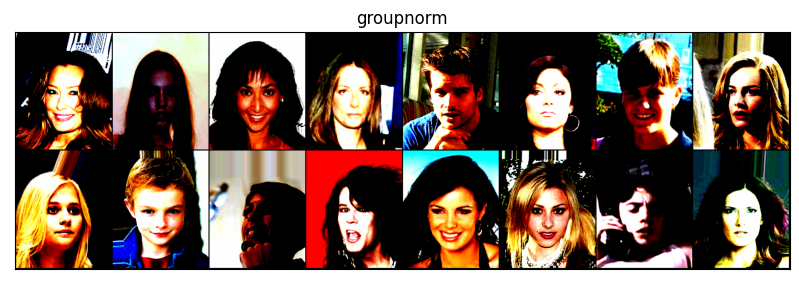

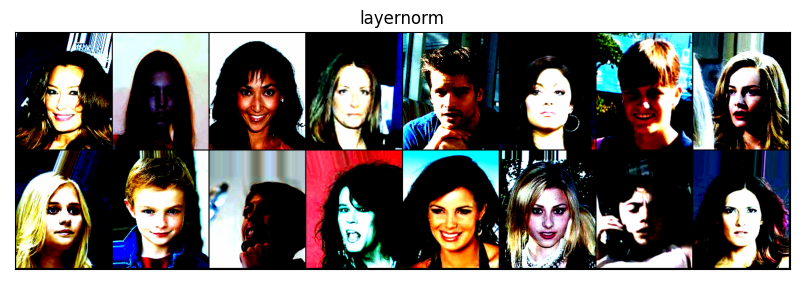

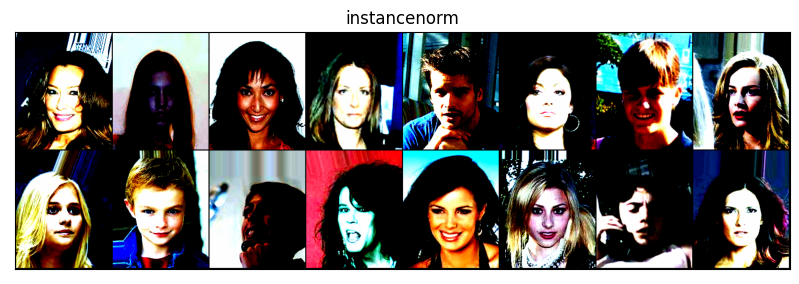

In [8]:
import torchvision.transforms.functional as F
from timeit import timeit
from torchvision.utils import make_grid
plt.rcParams["savefig.bbox"] = 'tight'
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
torch.manual_seed(10)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize=(10,5),ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torch.clamp(img, min=0, max=0.999)
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


modules = {'groupmap':gm, 'layermap':lm, 'instancemap':im, 'groupnorm':gn, 'layernorm':ln, 'instancenorm':inn}
for x, _ in dataloader:
    x=x.to(device)
    show(make_grid(x)); plt.title('original')
    for key in modules:
        %timeit -n 100 test = modules[key](x)
        out = modules[key](x)
        
        show(make_grid(out)); plt.title(key)
    
    break